In [ ]:
pip install neuralforecast

In [ ]:
pip install datasetsforecast

We will work with neuralforecast, as they have an out-of-the-box implementation of PatchTST. For the dataset, we use the datasetsforecast library, which includes all popular datasets for evaluating forecasting algorithms.

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

In [7]:
torch.cuda.is_available()

False

We use the Exchange dataset, which is a common benchmark dataset for long-term forecasting in research. The dataset contains daily exchange rates of eight countries relative to the US dollar, from 1990 to 2016. The dataset is made available through the MIT License.

In [8]:
Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

100%|██████████| 314M/314M [00:15<00:00, 20.4MiB/s]


Here, we see that we get three DataFrames. The first one contains the daily exchange rates for each country. The second one contains exogenous time series. The third one, contains static exogenous variables (like day, month, year, hour, or any future information that we know).

Here we only work with Y_df.

Then, let’s make sure that the dates have the right type.

In [9]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head()

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966


Above, we see that we have three columns. The first column is a unique identifier and it is necessary to have an id column when working with neuralforecast. Then, the ds column has the date, and the y column has the exchange rate.

In [10]:
Y_df['unique_id'].value_counts()

0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: unique_id, dtype: int64

Each unique id corresponds to a country, and that we have 7588 observations per country.

Let’s plot the series for the first country (unique_id = 0)

In [11]:
n_time = len(Y_df.ds.unique())
val_size = 760
test_size = 1517

print(n_time, val_size, test_size)

Y_df.groupby('unique_id').head(2)

7588 760 1517


,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
7588,1,1990-01-01,-0.361671
7589,1,1990-01-02,-0.367639
15176,2,1990-01-01,0.735367
15177,2,1990-01-02,0.729629
22764,3,1990-01-01,-1.164373
22765,3,1990-01-02,-1.170907
30352,4,1990-01-01,2.851890
30353,4,1990-01-02,2.851890


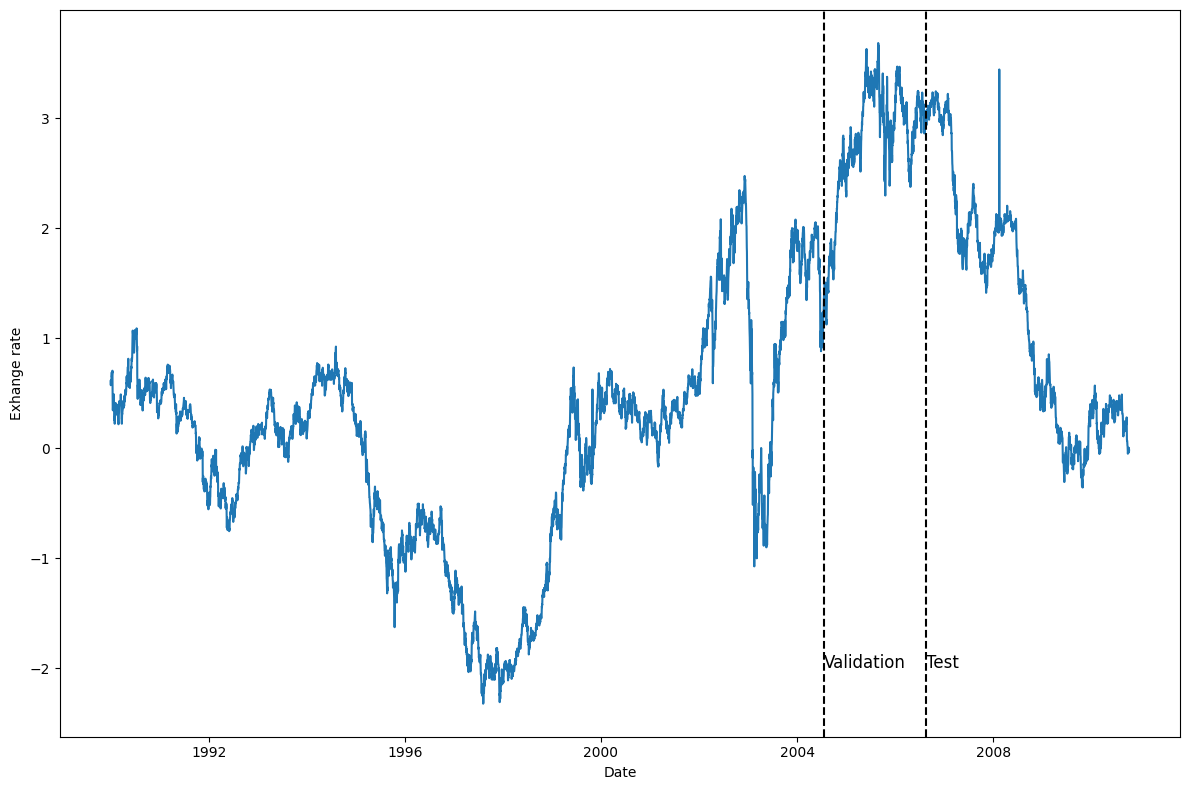

In [12]:
u_id = '0'

x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_plot

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'Test', fontsize=12)

plt.tight_layout()

We can see that we have fairly noisy data with no clear seasonality.

### Modeling
Let’s get started on modelling with *neuralforecast.*

First, we need to set the horizon. In this case, we use 96 time steps, as this horizon is also used in the PatchTST paper.

Then, to have a fair evaluation of each model, to set the input size to twice the horizon (so 192 time steps), and set the maximum number of epochs to 50. All other hyperparameters are kept to their default values.


In [13]:
horizon = 96

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Then, we initialize the *NeuralForecastobject*, by specifying the models we want to use and the frequency of the forecast, which in this is case is daily.

In [14]:
nf = NeuralForecast(models=models, freq='D')

We are now ready to make predictions.

### Forecasting

To generate predictions, we use the cross_validation method to make use of the validation and test sets. It will return a DataFrame with predictions from all models and the associated true value.

In [15]:
preds_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y
0,0,2006-08-16,2006-08-15,2.935175,2.944641,2.907044,2.948076
1,0,2006-08-17,2006-08-15,2.926820,2.963531,2.927490,3.049320
2,0,2006-08-18,2006-08-15,2.936348,2.958615,2.932774,3.064168
3,0,2006-08-19,2006-08-15,2.920622,2.910906,2.948636,3.005783
4,0,2006-08-20,2006-08-15,2.927449,2.993620,2.943420,3.010031


As we can see, for each id, we have the predictions from each model as well as the true value in the y column.

Now, to evaluate the models, we have to reshape the arrays of actual and predicted values to have the shape (number of series, number of windows, forecast horizon).

In [17]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values

n_series = len(Y_df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

print(y_true.shape)
print(y_pred_nhits.shape)

(8, 1422, 96)
(8, 1422, 96)


With that done, we can optionally plot the predictions of our models. Here, we plot the predictions in the first window of the first series.

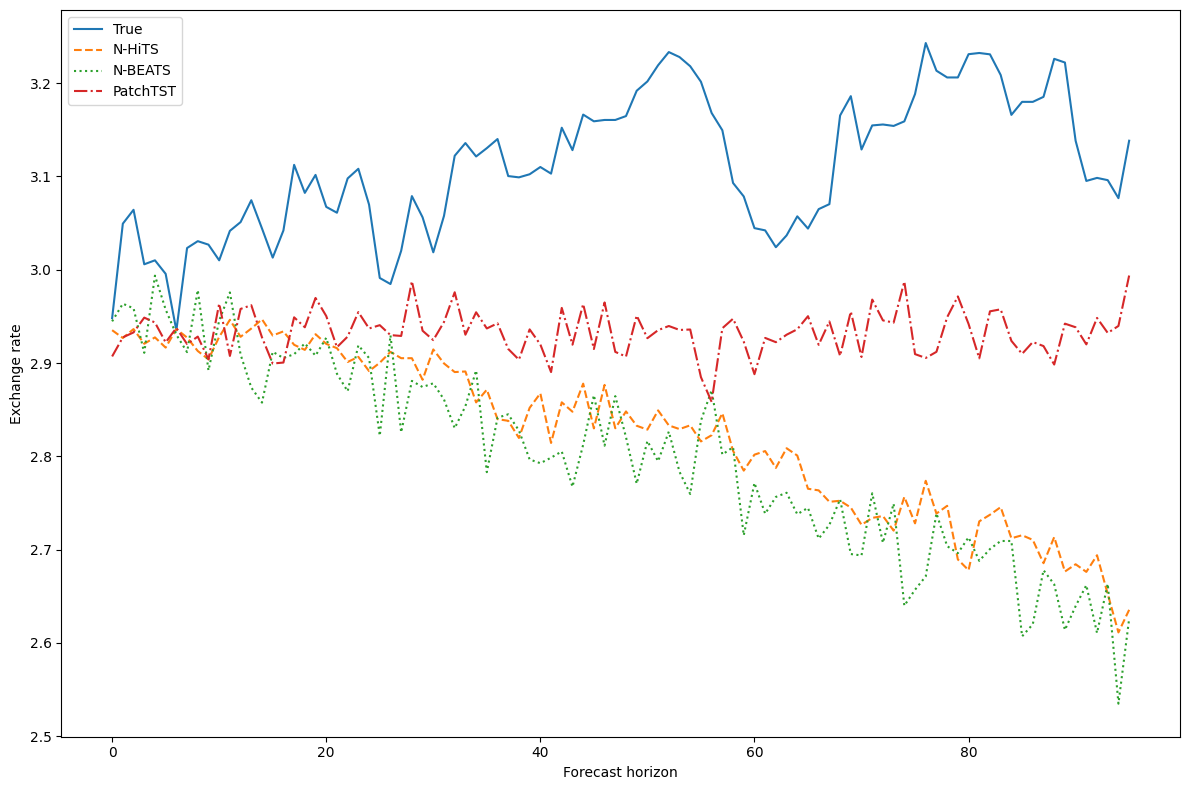

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

This figure is a bit underwhelming, as N-BEATS and N-HiTS seem to have predictions that are very off from the actual values. However, PatchTST, while also off, seems to be the closest to the actual values.

Of course, we must takes this with a grain of salt, because we are only visualizing the prediction for one series, in one prediction window.

### Evaluation
So, let’s evaluate the performance of each model. To replicate the methodology from the paper, we use both the MAE and MSE as performance metrics.

In [19]:
data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.197755,0.197712,0.198060
mse,0.078293,0.078195,0.081693


In the table above, we see that N-BEATS is the champion model as it achieves the lowest MAE and MSE.

Of course, this was not the most thorough experiment, as we only used one dataset and one forecast horizon. Still, it is interesting to see that a Transformer-based model can compete with state-of-the-art MLP models.